# This notebook is dedicated to the plotting of the different results

In [66]:
import os, sys
import numpy                as np
import matplotlib.pyplot    as plt
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn              as sns
import pickle
from scipy.stats import multivariate_normal, truncnorm, norm
import itertools
from scipy.stats import bootstrap
from matplotlib.pyplot import figure


In [127]:
%run utils_plot_errors.ipynb
seed_x = 123456 #indicates which design $x_j$ to work with
sigma = [0.9,0.9,0.3]
suff = "" #suffix for potential smallnoise study
results_measures = pd.read_csv(f"measurement_points/results_measures_seed_x{seed_x}" + suff + ".csv", index_col=0)
true_values = results_measures.iloc[:10,:] #get true values
results_measures = results_measures.iloc[10:,:] #get noisy observations

pre_path = f"seed_x{seed_x}" + suff + "/"


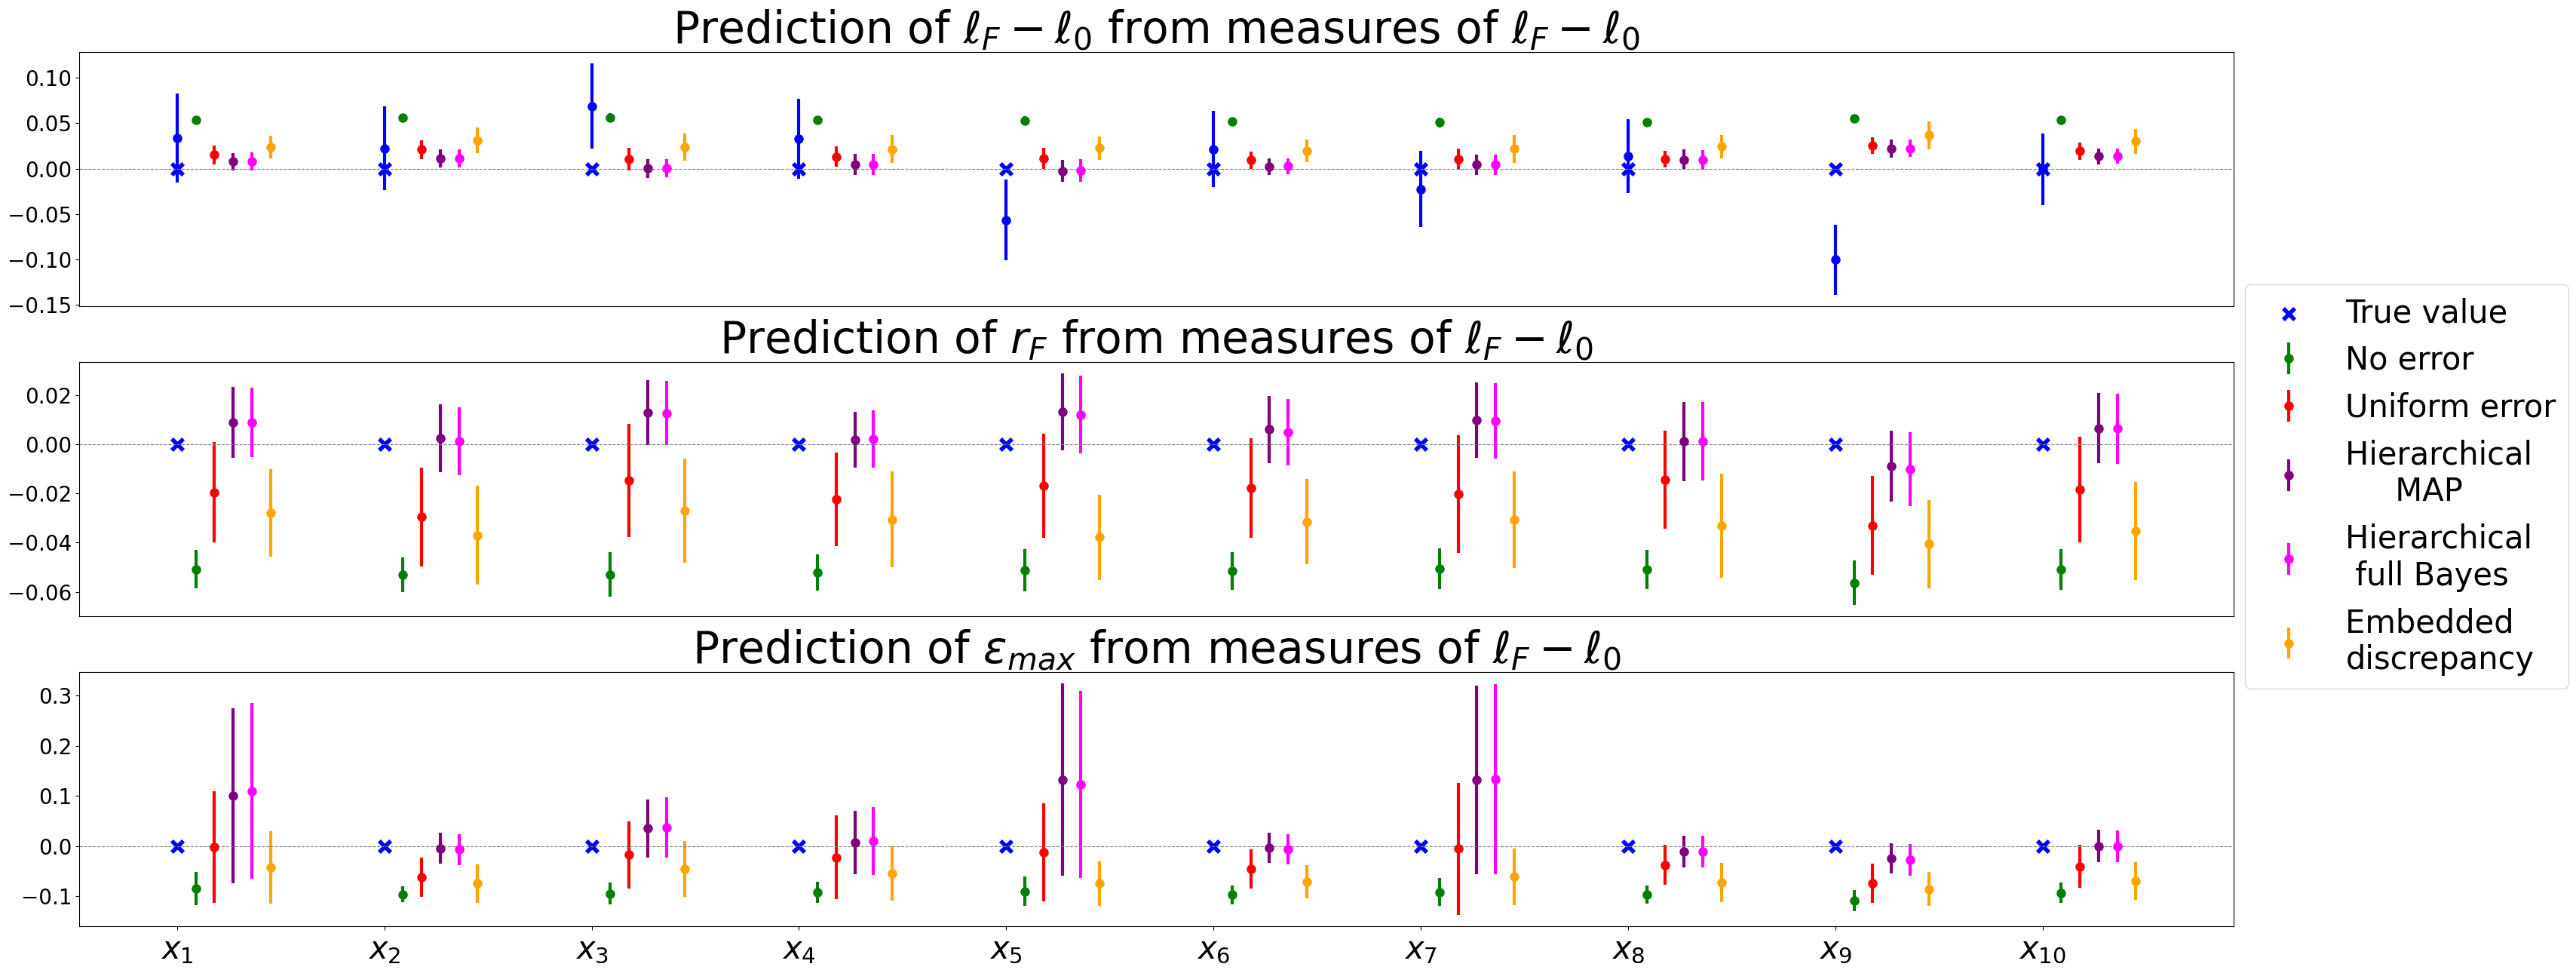

In [126]:
plot_mean_std(1, pre_path, savefig = False) 

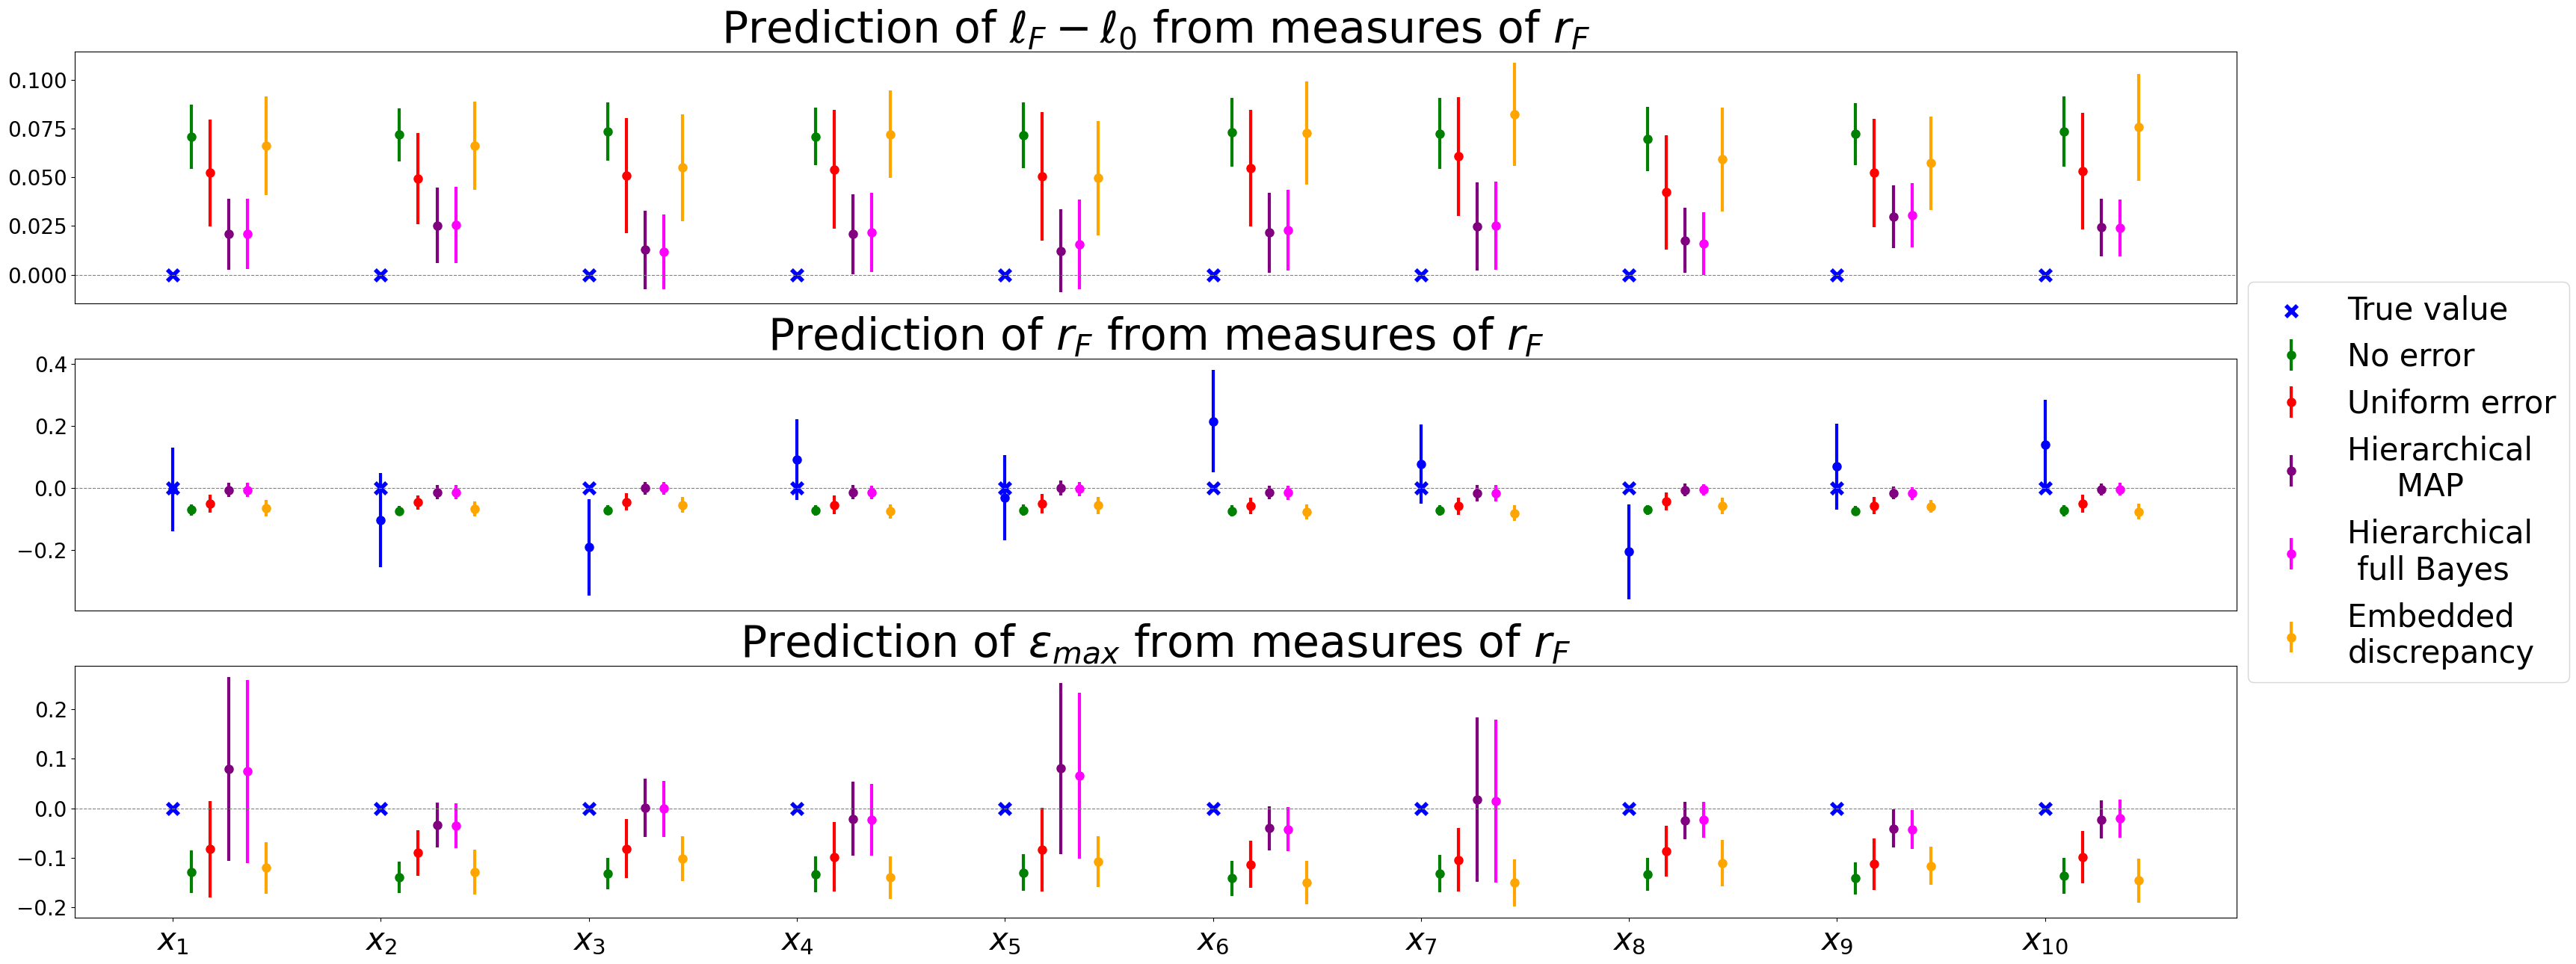

In [125]:
plot_mean_std(2, pre_path, savefig = False) 

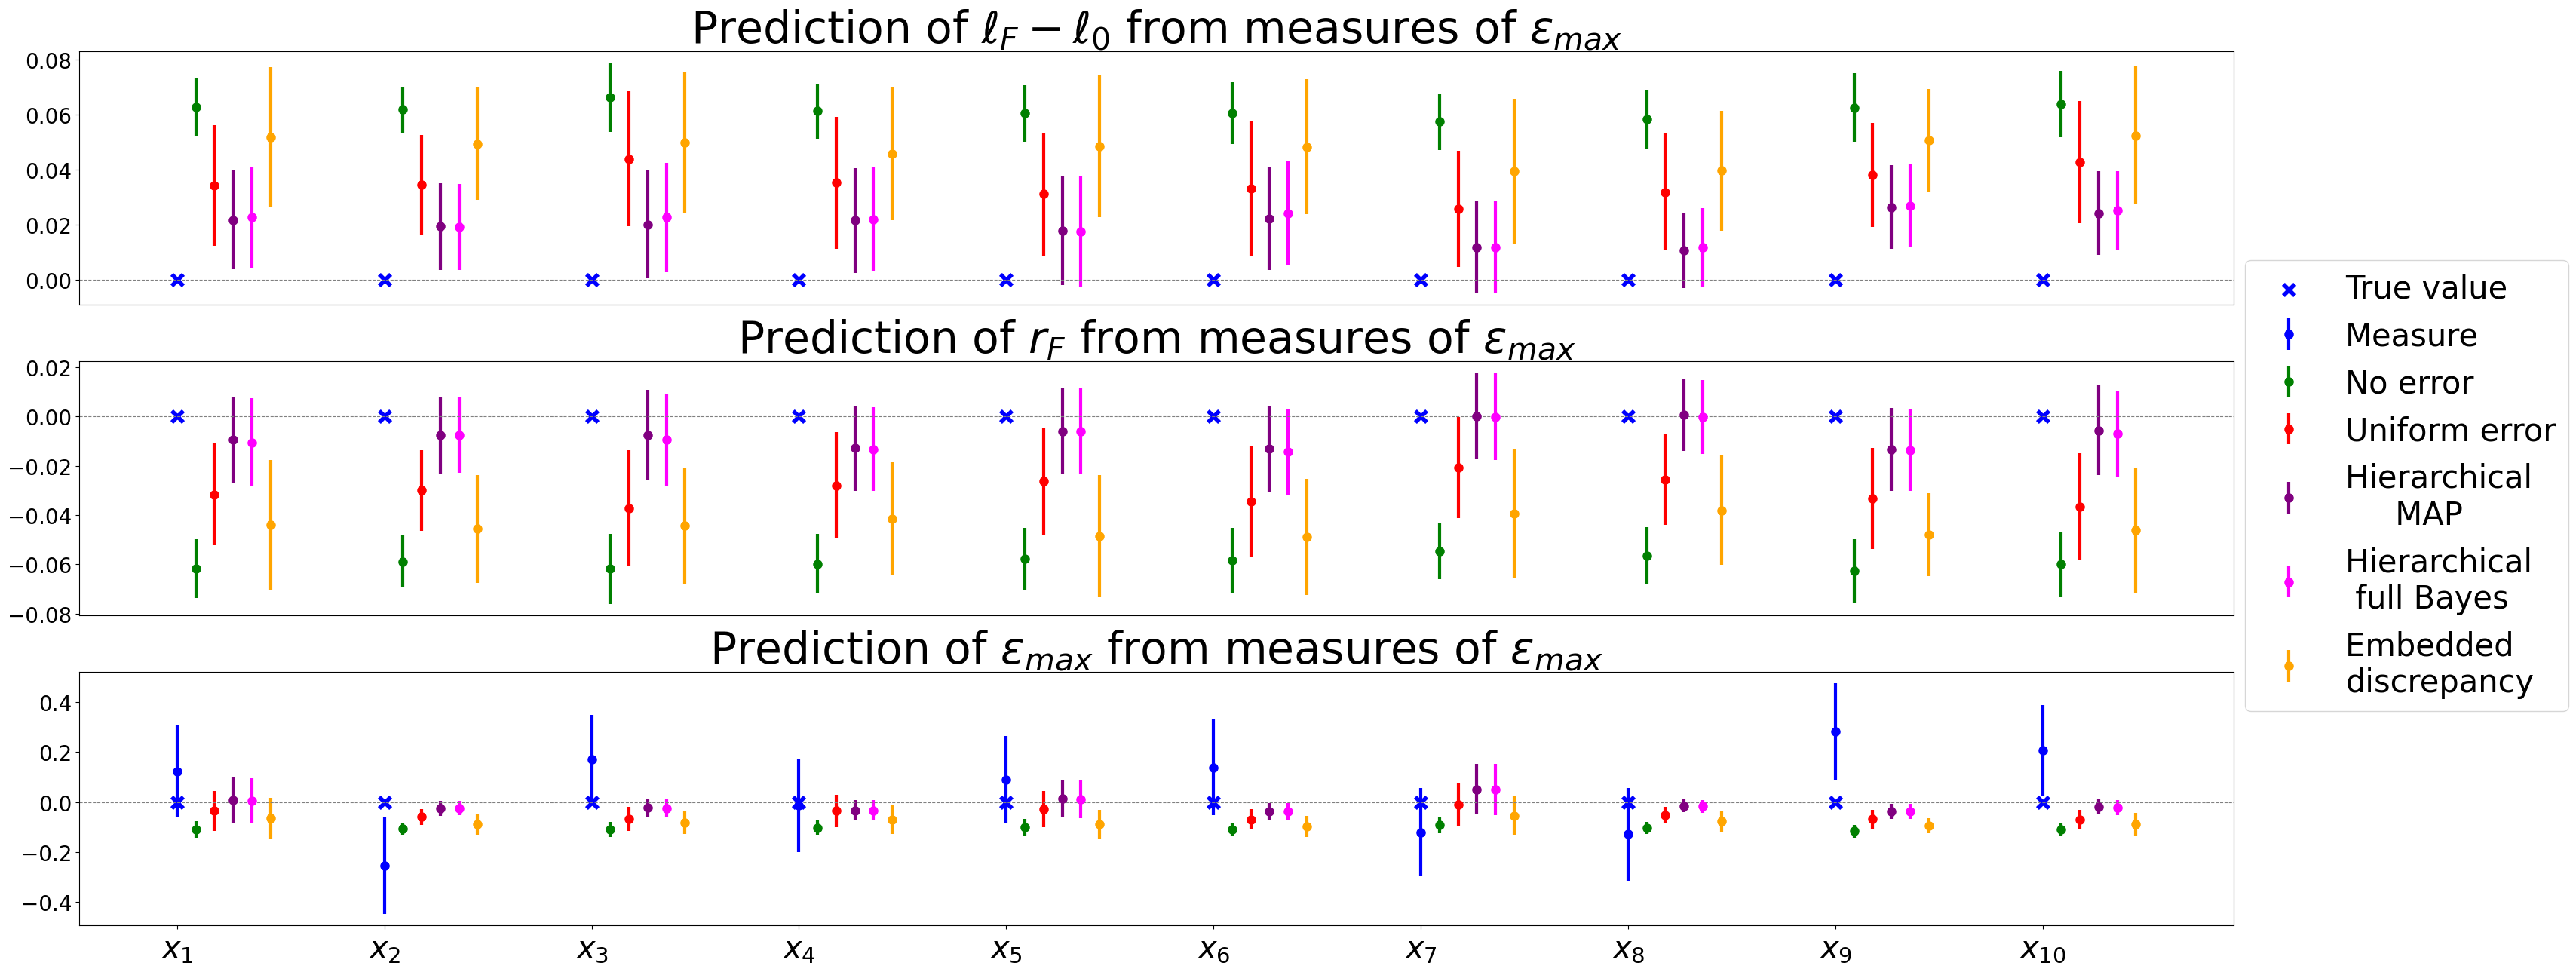

In [124]:
plot_mean_std(3, pre_path, savefig = False) 


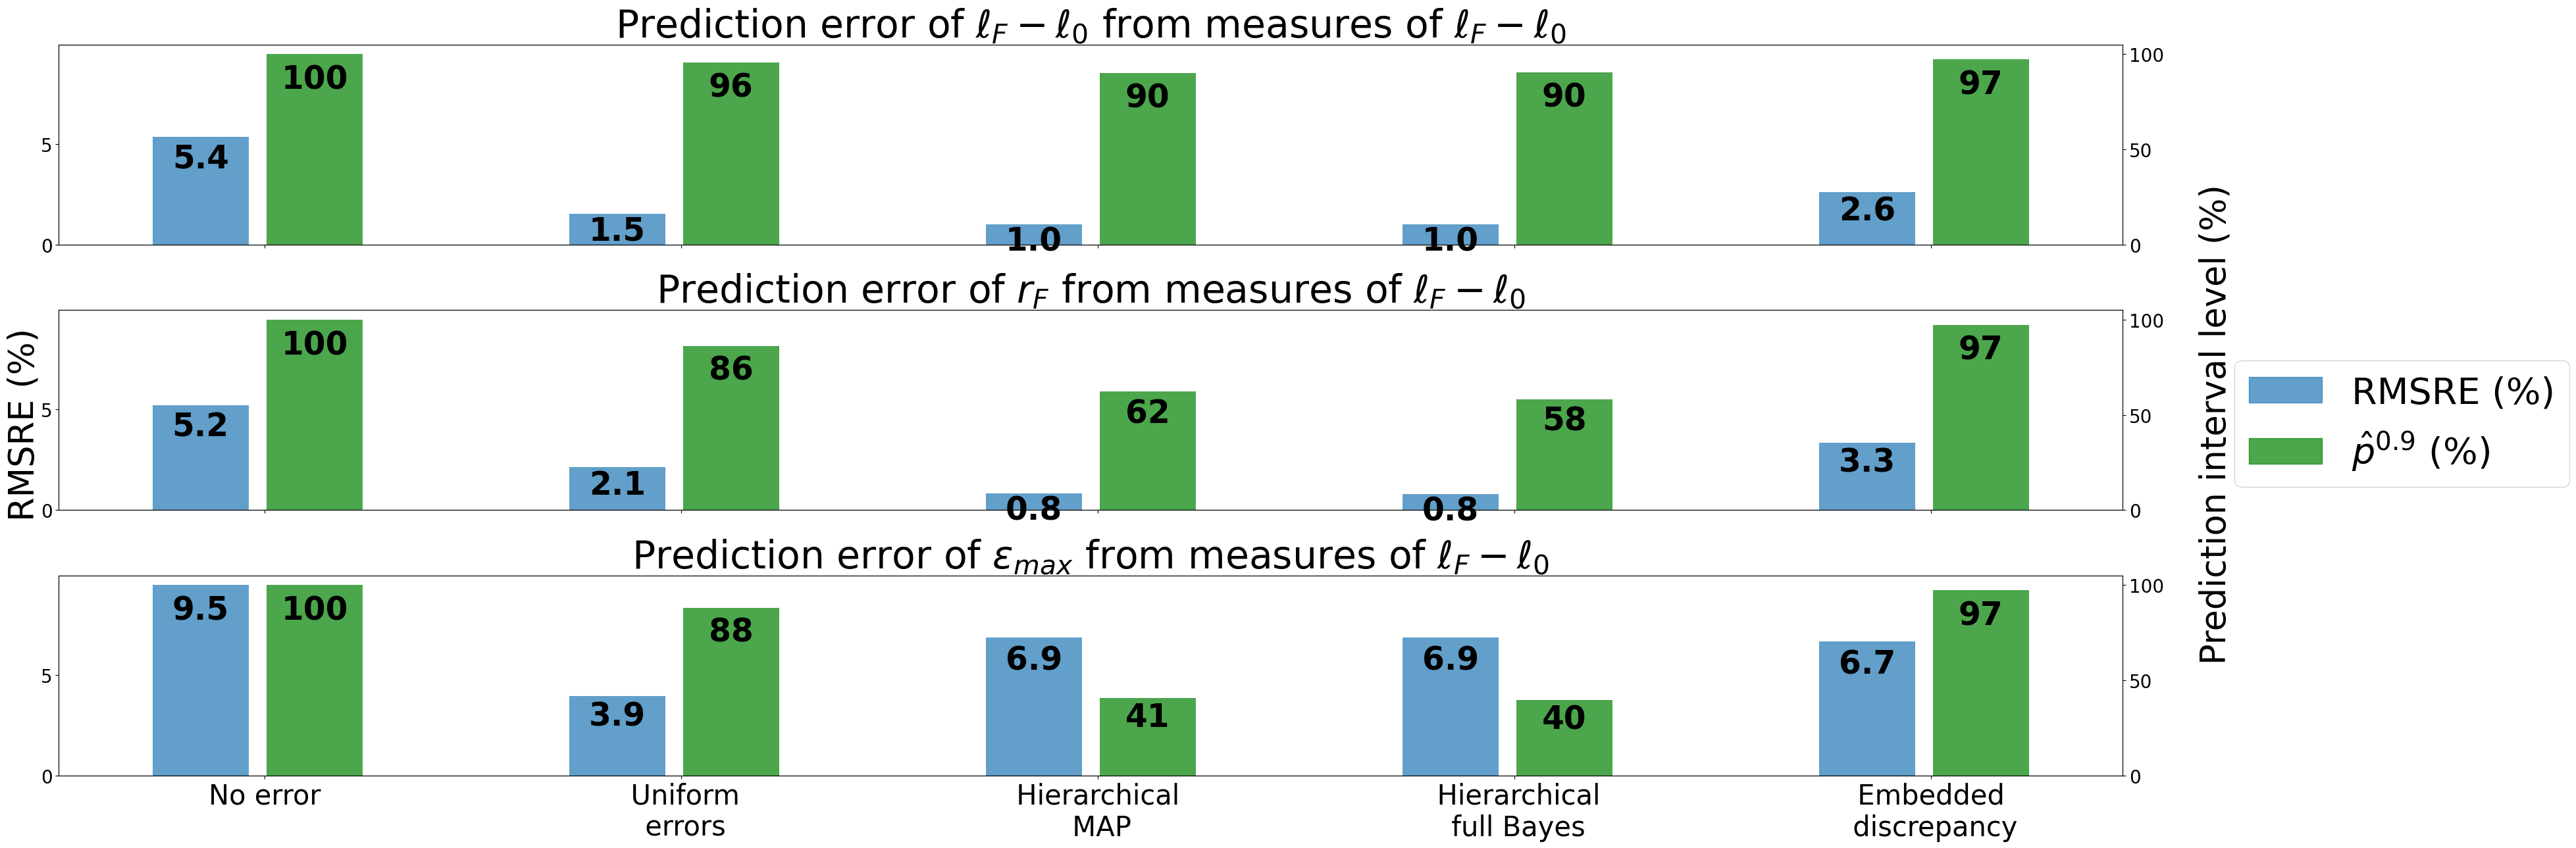

In [116]:
plot_errors(1, pre_path, savefig = False )


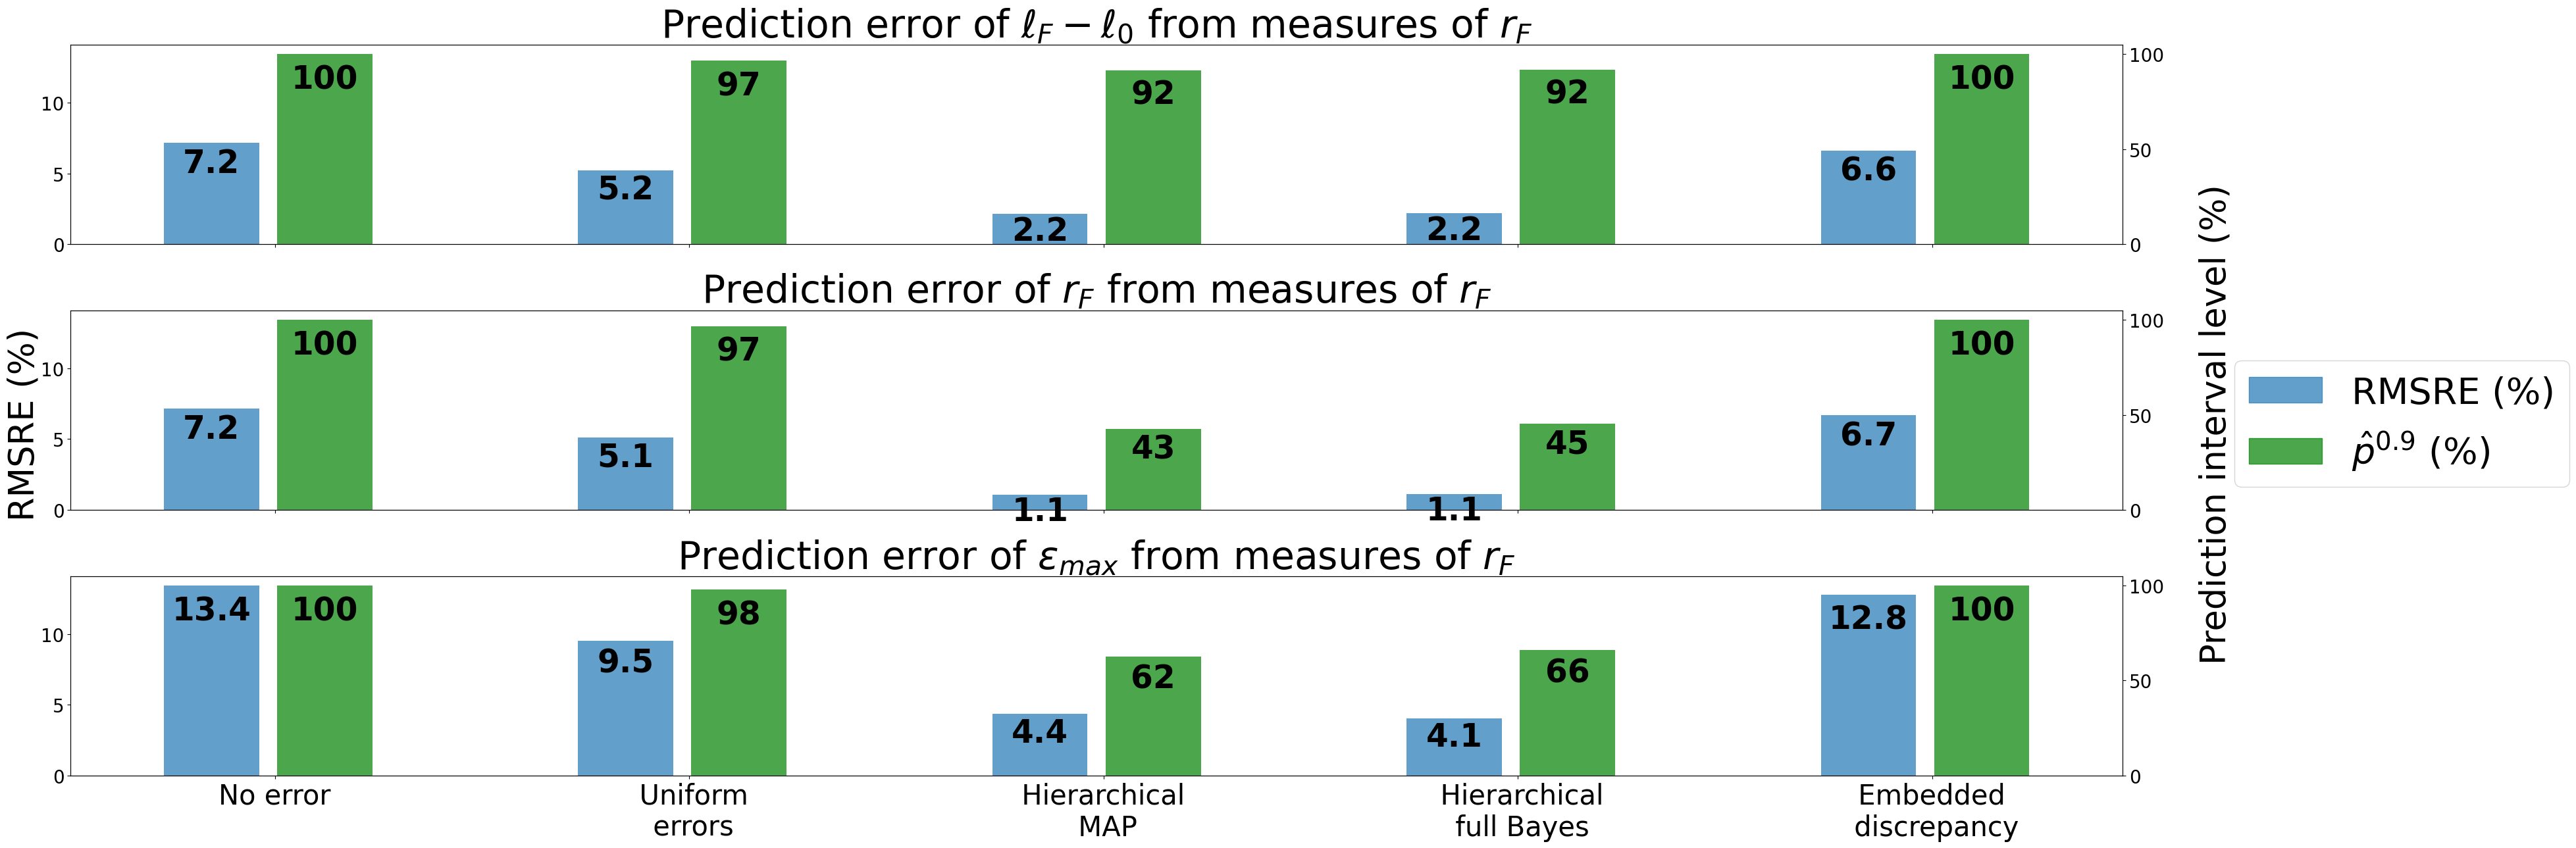

In [117]:
plot_errors(2, pre_path, savefig = False )

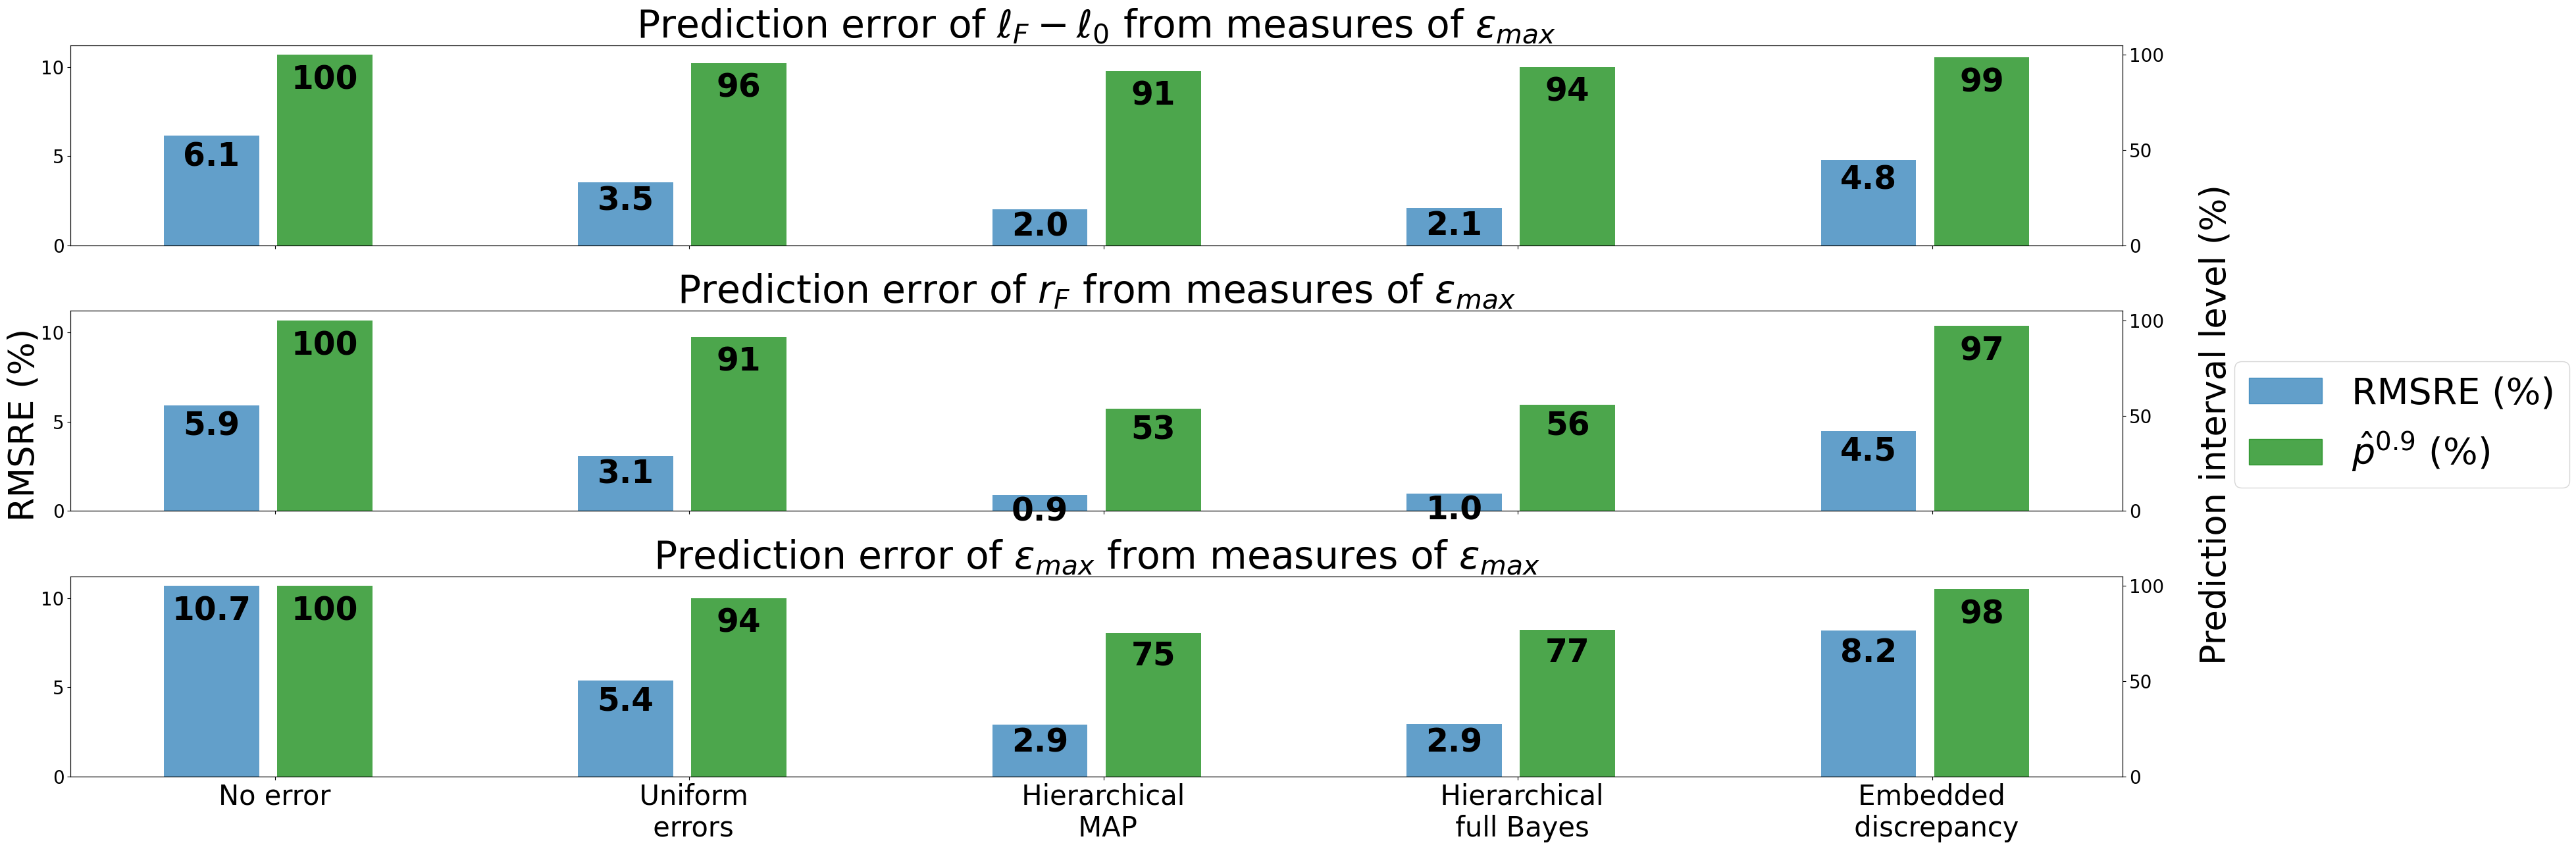

In [118]:
plot_errors(3, pre_path, savefig = False )


# Below is the plot of an example of posterior sample obtained for $\Lambda$ 

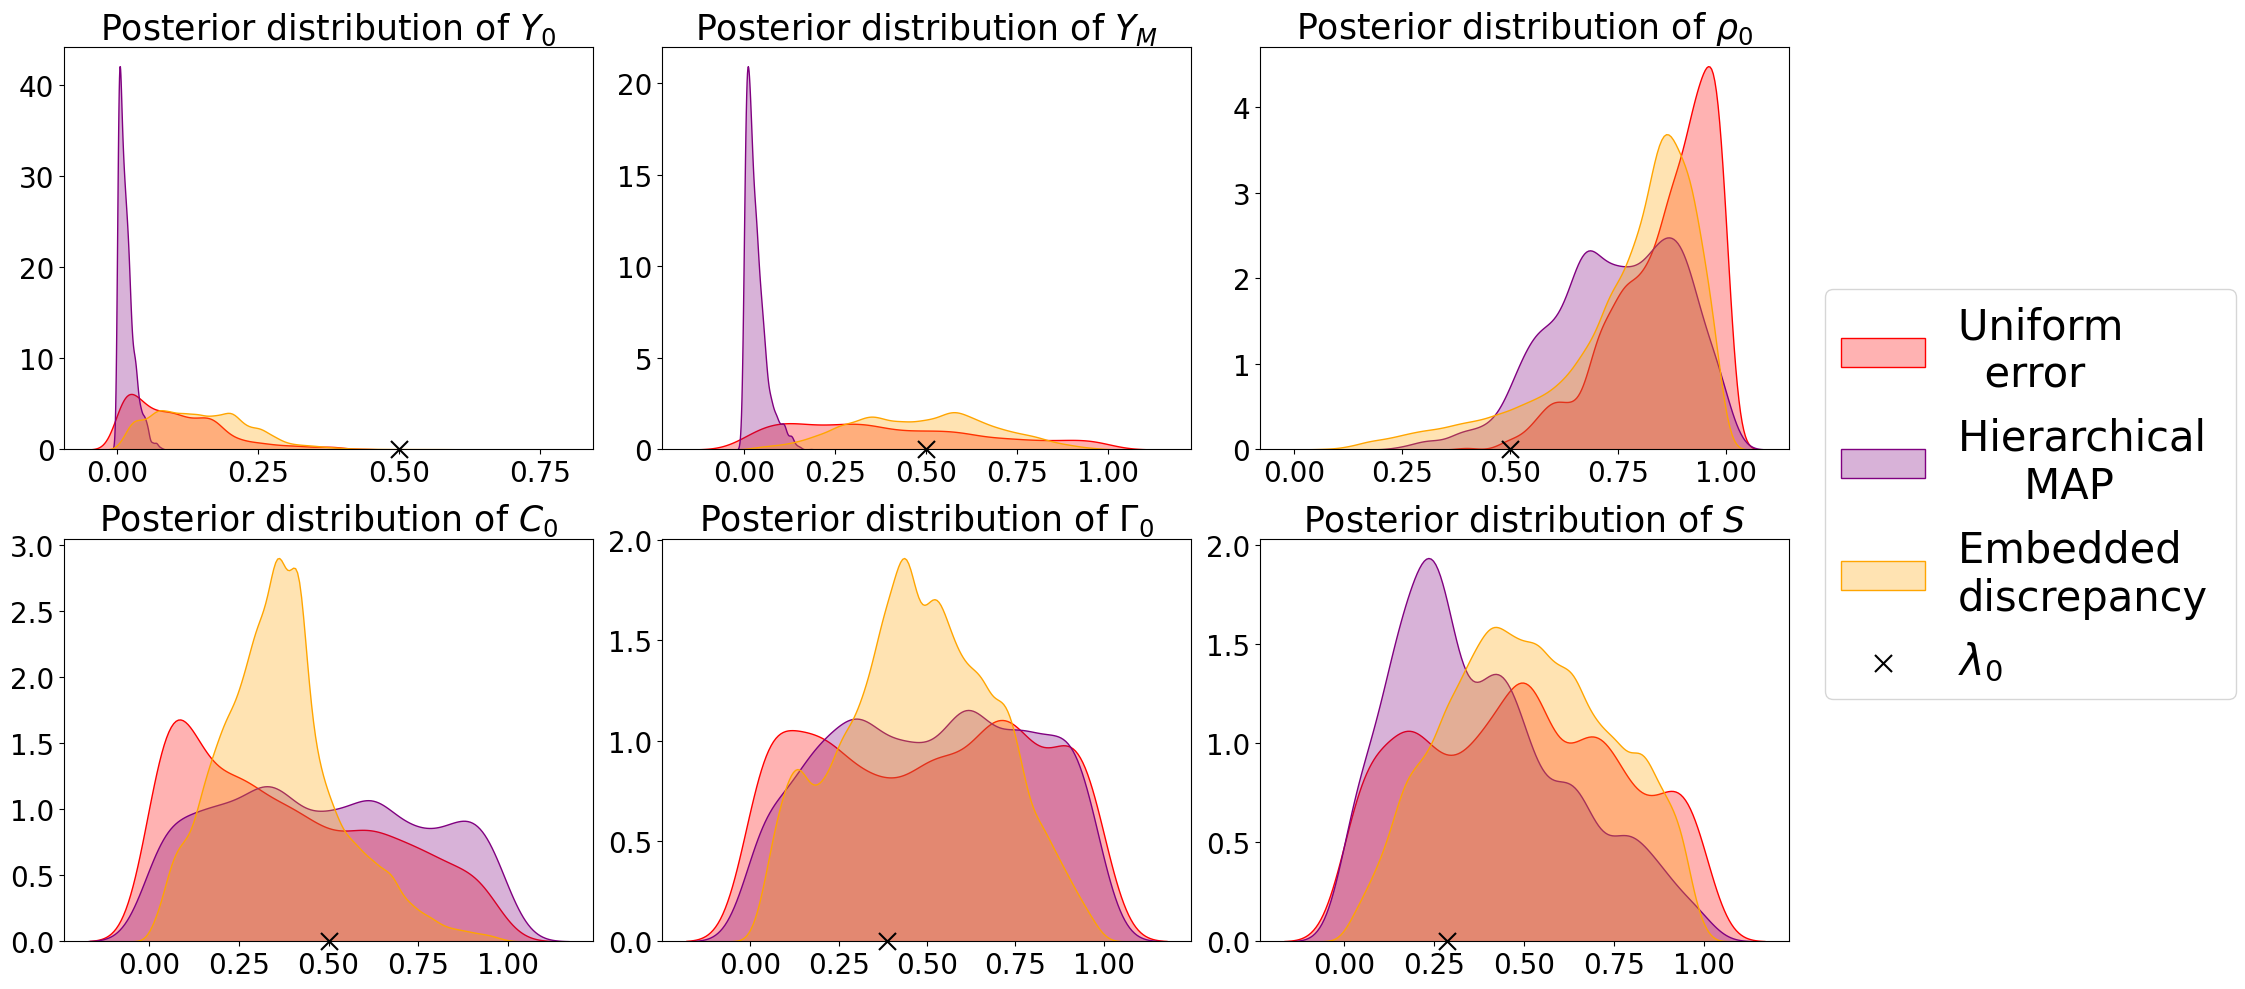

In [76]:
params = [r'$Y_0$', r'$Y_M$',r'$\rho_0$', r'$C_0$', r'$\Gamma_0$', r'$S$'] #variable names
bMINlambda = np.array([330, 70,  8000, 3000, 0.1, 0.1]) #lower bounds
bMAXlambda = np.array([470, 150, 10000, 5000, 5, 5.0]) #upper bounds

lambda_0 = (np.array([400,110,9000,4000,2,1.5])-bMINlambda)/(bMAXlambda-bMINlambda) #lambda0 used for the measures

index_calib=1 #which calibration variable
idx_loo = 9 #which observation point x_j

sample_unif = pd.read_csv(pre_path + f"uniform_error/calib_{index_calib}/lambd_post_{idx_loo}.csv", index_col = 0).values #uniform error sample
sample_hier = pd.read_csv(pre_path + f"hierarchical_model/calib_{index_calib}/lambd_post_{idx_loo}.csv", index_col = 0).values #hierarchical model sample
sample_embed = pd.read_csv(pre_path + f"embedded_discrepancy/calib_{index_calib}/lambd_post_{idx_loo}.csv", index_col = 0).values #embedded discrepancy sample
sample_unif = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_unif) #normalized sample
sample_hier = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_hier) #normalized sample


r = 30
unifo = np.linspace(0,1,r)*2-1 #uniform sample in 1D for \xi
unifo = np.concatenate([unifo]*len(sample_embed)) 
sample_embed = np.repeat(sample_embed, r, axis = 0) 
sample_embed = sample_embed[:,:6]+np.apply_along_axis(lambda x: x*unifo, 0, sample_embed[:,6:]) #lambda^1 + lambda^2 \xi on each marginal


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Tracer les KDE pour chaque colonne
for i in range(6):
    kde_unif = sns.kdeplot(sample_unif[:, i], ax=axes[i], label='Uniform \n  error', color='red', fill=True, alpha=0.3)
    kde_hier = sns.kdeplot(sample_hier[:, i], ax=axes[i], label='Hierarchical \n     MAP', color='purple', fill=True, alpha=0.3)
    kde_embed = sns.kdeplot(sample_embed[:, i], ax=axes[i], label='Embedded \ndiscrepancy', color='orange', fill=True, alpha=0.3)
    
    
    axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    axes[i].set_title(f'Posterior distribution of {params[i]}', fontsize=25)
    axes[i].tick_params(axis='both', labelsize=20)
    axes[i].set_ylabel('')  # Supprimer le titre de l'axe Y
    axes[i].scatter(lambda_0[i], 0, color='black', marker='x', s=150, label=r'$\lambda_0$',clip_on=False)

# Créer une légende globale
handles, labels = axes[3].get_legend_handles_labels()  # Récupérer les objets courbes et les labels d'un subplot

# Ajouter la légende globale à droite
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=30)

# Ajuster l'espacement des subplots
plt.tight_layout()

plt.savefig(pre_path + f"plots/compare_samples.pdf",bbox_inches='tight')

# Afficher la figure
plt.show()

# Below is the code to plot the estimated posterior distribution of $\boldsymbol{A}$, and the levels of confidence confidence level $\gamma(\boldsymbol{\alpha})$ associated with $p(\boldsymbol{\alpha} \mid \boldsymbol{y_{1,\text{obs}}}) \leq \beta p(\boldsymbol{\alpha}^{\star}_\ell \mid \boldsymbol{y_{1,\text{obs}}})$

In [4]:
%run gp_simus.ipynb #notebook for the metamodel 
%run utils_calib.ipynb #notebook with needed function for the methods

index_lambda_p = [2,3,4,5] #indexes of the four physical parameters
index_lambda_q = [0,1] #indexes of the two numerical parameters
scale = 0.45 #std deviation of the truncated gaussian prior

with open(f'surrogate_models/mm_list_seed_x{seed_x}.pkl', 'rb') as f:
    mm_list = pickle.load(f) #get metamodel hyperparameters

index_calib = 3 #index of the calibration variable
alpha_map_list = pd.read_csv(pre_path + f"hierarchical_model/calib_{index_calib}/alpha_df.csv", index_col = 0).values #get the estimated alpha_maps
idx_loo = 5 #observation point
alpha_star = alpha_map_list[idx_loo] #estimated alpha_map

M = pd.read_csv(pre_path + f"/hierarchical_model/calib_{index_calib}/sample_sizes.csv", index_col = 0).values[idx_loo,0] #get the sample size used in the algorithm to investigate alpha_map
alpha_min = -10
alpha_max = 10
delta_alpha = 4

np.random.seed(123456)
df_Lambda = sample_Lambda(alpha = alpha_star, M = M, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, scale = scale) #sample lambda from p(lambda given alpha_map)
Ysimu_list, Ystd_list, stored_likelihoods = get_likelihoods_dflambda(df_Lambda = df_Lambda.values, sigma = sigma, myCODE = myCODE, results_measures = results_measures, index=[index_calib], std_code = True, idx_loo = idx_loo) #get the likelihoods

size = 15 #size of the grid 
beta = 1.05 #margin coefficient

bounds = [(max(alpha_star[ii] - delta_alpha,alpha_min), min(alpha_max, alpha_star[ii]+delta_alpha)) for ii in range(len(alpha_star))] #bounds of the grid

alpha_grid = np.array(list(itertools.product(np.linspace(bounds[0][0],bounds[0][1],size), np.linspace(bounds[1][0],bounds[1][1],size))))

p_alphastar = p_lambda_df(df_Lambda = df_Lambda, alpha = alpha_star, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, scale = scale) #prior coefficient p(lambda_k | alpha_map)
ratios_dic = {} #compute the importance sampling ratios for every alpha in the grid
for ii in range(len(alpha_grid)):
    alpha = alpha_grid[ii]
    ratios_dic[str(alpha)] = np.array(p_lambda_df(df_Lambda = df_Lambda, alpha = np.array(alpha), index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, scale = scale)/p_alphastar).reshape(len(p_alphastar),1)
    
is_terms = np.concatenate([stored_likelihoods*ratios_dic[str(alpha)] for alpha in alpha_grid], axis=1) #likelihood times is ratios (p(yobs | lambda_k) p(lambda_k | alpha)/p(lambda_k | alpha_star)
is_terms_diff = is_terms - beta*stored_likelihoods #(p(yobs | lambda_k) (p(lambda_k | alpha)/p(lambda_k | alpha_star) - \beta)
likeli_grid_true = np.mean(is_terms, axis=0) #the estimator of the likelihood is the mean of is_terms
likeli_grid_diff = np.mean(is_terms_diff, axis = 0)

stds = np.apply_along_axis(np.mean, 1, bootstrap((is_terms_diff,), np.std, n_resamples=500, vectorized=True, axis=0, batch = 25 ).bootstrap_distribution) #compute the variance of is_terms_diff by bootstrap sampling
confidence = norm.cdf(np.sqrt(M)*(-likeli_grid_diff)/stds) #compute the confidence level



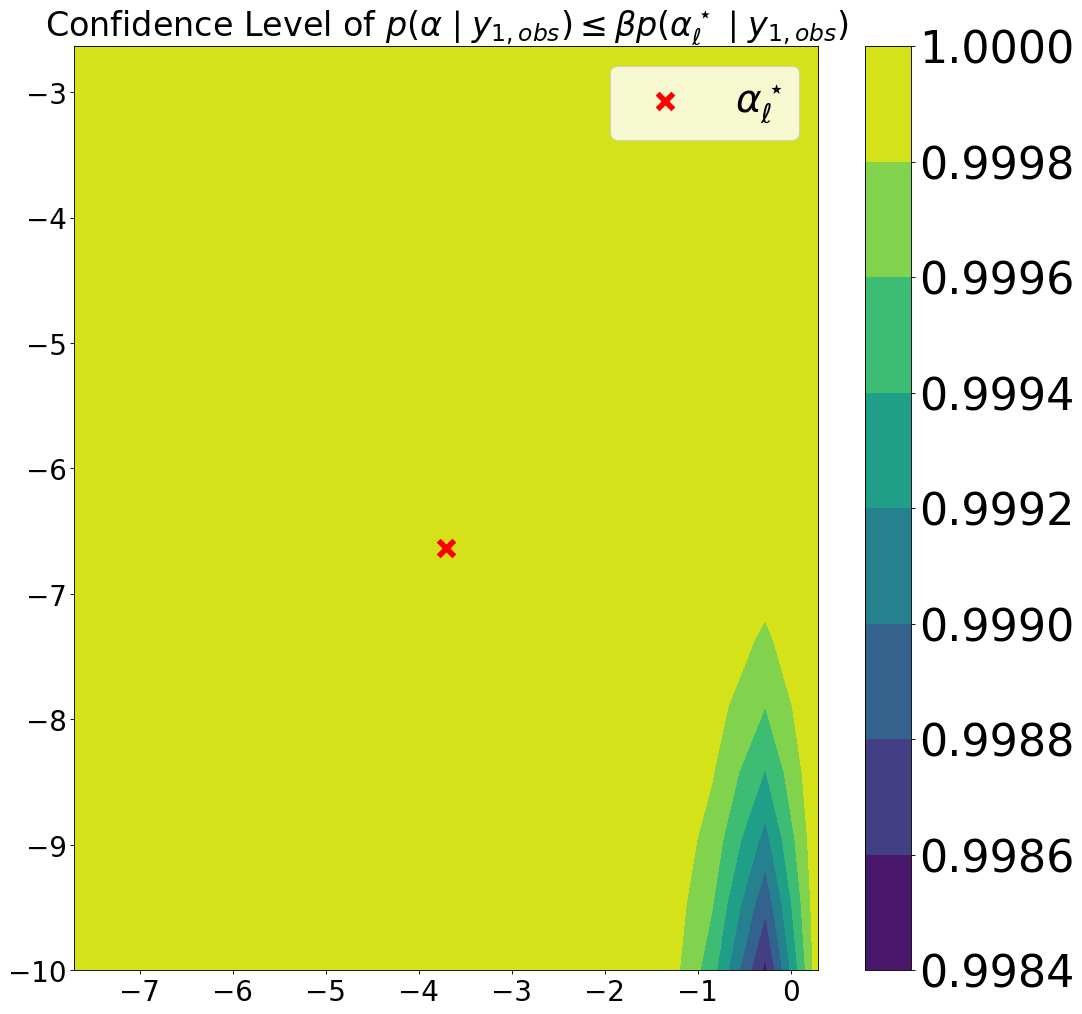

In [12]:
figure(figsize=(15, 15), dpi=80) #plot the confidence level ac
contour = plt.contourf(np.linspace(bounds[0][0],bounds[0][1],size),np.linspace(bounds[1][0],bounds[1][1],size), np.transpose(confidence.reshape(size,size)), cmap='viridis')
plt.scatter(alpha_star[0], alpha_star[1], marker='x', color='red', s=200, linewidths=5, label=r'$\alpha^\star_\ell$')
colorbar = plt.colorbar(contour, label='')
colorbar.ax.tick_params(labelsize=40)
plt.title(r"Confidence Level of $p(\alpha \mid y_{1,obs}) \leq \beta p(\alpha^\star_{\ell} \mid y_{1,obs})$", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend(loc='upper right', fontsize=35)
plt.savefig(pre_path + f"plots/confidence_alpha.pdf",bbox_inches='tight')
plt.show()

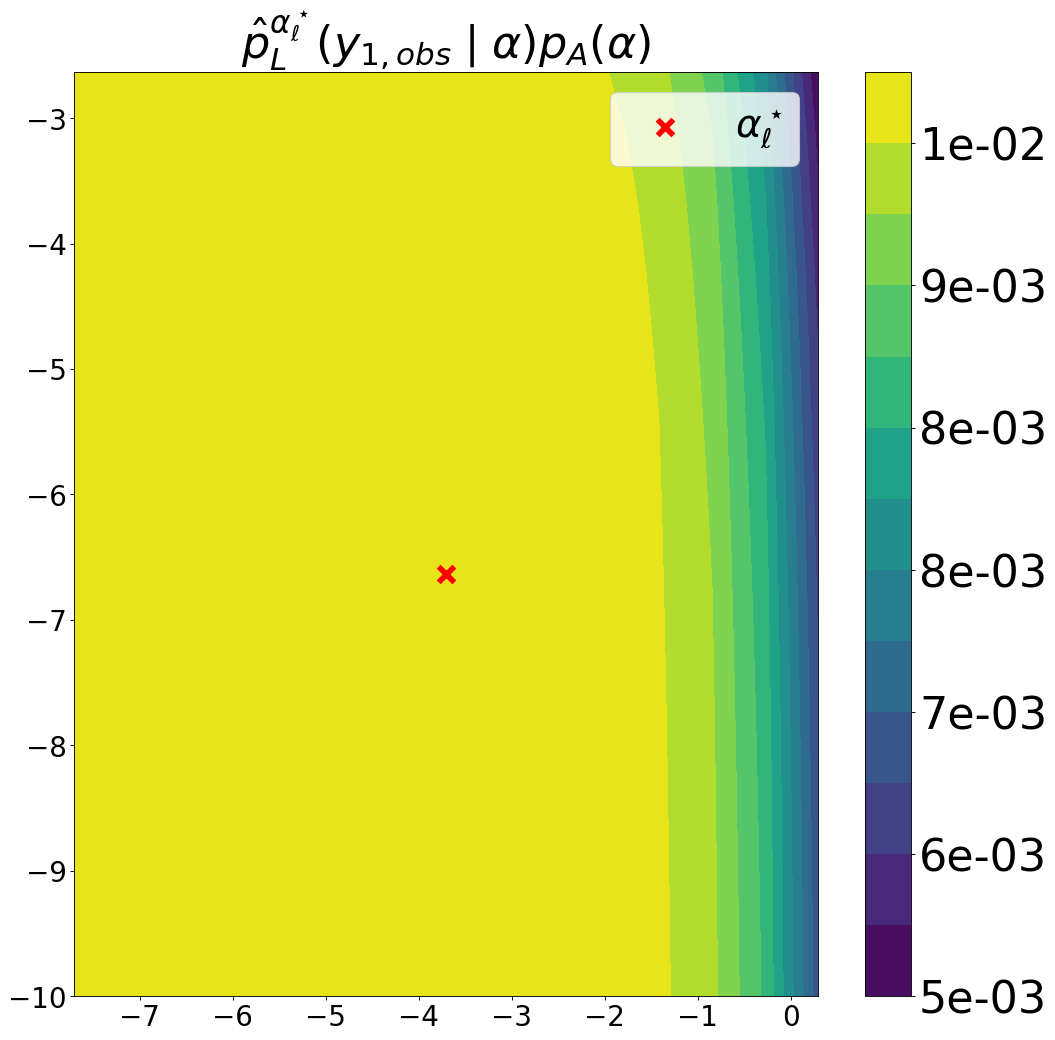

In [13]:
figure(figsize=(15, 15), dpi=80)
contour = plt.contourf(np.linspace(bounds[0][0],bounds[0][1],size),np.linspace(bounds[1][0],bounds[1][1],size), np.transpose(likeli_grid_true.reshape(size,size)), cmap='viridis', levels = 16)
plt.scatter(alpha_star[0], alpha_star[1], marker='x', color='red', s=200, linewidths=5, label=r'$\alpha^\star_\ell$')
colorbar = plt.colorbar(contour, label='',format='%.0e')
colorbar.ax.tick_params(labelsize=40)

plt.title(r"$\hat{p}^{\alpha^\star_{\ell}}_L(y_{1,obs} \mid \alpha)p_{A}(\alpha)$", fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend(loc='upper right', fontsize=35)
plt.savefig(pre_path + f"plots/likeli_alpha.pdf",bbox_inches='tight')
plt.show()